In [1]:
import numpy as np
import pandas as pd
import pickle

import random
import keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, BatchNormalization
from keras.models import load_model

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt  
%matplotlib inline 

saved_model = "nn_weights_inpaint_mix.hdf5"

img_shape = (32,32,3)

def create_pairs(db_ori, db_adv, frm_pos, end_pos):
    
    pairs = []
    labels = []
    for i in range(frm_pos, end_pos):
        pairs += [db_ori[i]]
        pairs += [db_adv[i]]
        labels += [0, 1]
    return np.array(pairs), np.array(labels)

/home/fzuo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
with open('cw0-inpaint-test.pkl', 'rb') as handle2:
    db_inpaint_cw0_test = pickle.load(handle2)

with open('jsma-inpaint-test.pkl', 'rb') as handle4:
    db_inpaint_jsma_test = pickle.load(handle4)

adv_test = np.concatenate([db_inpaint_cw0_test, db_inpaint_jsma_test])
print(adv_test.shape)

(2000, 2, 32, 32, 3)


In [3]:
with open('ben_test.pkl', 'rb') as handle2:
    ben_test = pickle.load(handle2)

te_pairs, te_y = create_pairs(ben_test, adv_test, 0, 2000)

print(te_pairs.shape)
print(te_y.shape)

(4000, 2, 32, 32, 3)
(4000,)


In [4]:
## new sub-networks
def create_base_network():
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=img_shape)
    x = Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=img_shape)(input)
    x = Conv2D(64, kernel_size=(3, 3),activation='relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='softmax')(x)
    return Model(input, x)

# network definition
base_network = create_base_network()

input_a = Input(shape=img_shape)
input_b = Input(shape=img_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

In [5]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [6]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

model.load_weights(saved_model)

In [7]:
pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
   
pred_1d = pred[:,0]

fpr, tpr, _ = roc_curve(te_y, pred_1d, pos_label=0)
roc_auc = auc(fpr, tpr)*100

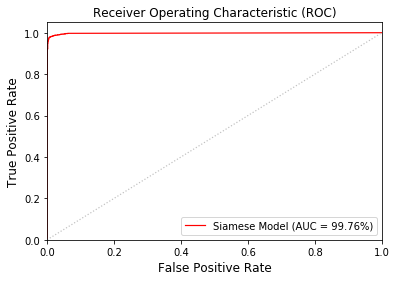

In [8]:
plt.figure()
plt.plot(fpr, tpr, color='red', linewidth = 1.2, label='Siamese Model (AUC = %0.2f%%)' % roc_auc)

plt.plot([0, 1], [0, 1], color = 'silver', linestyle = ':', linewidth = 1.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()